# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
- \begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation},
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math
from timeit import default_timer as timer

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, 'wb').write(r.content)

mat = loadmat(fileNames[0])

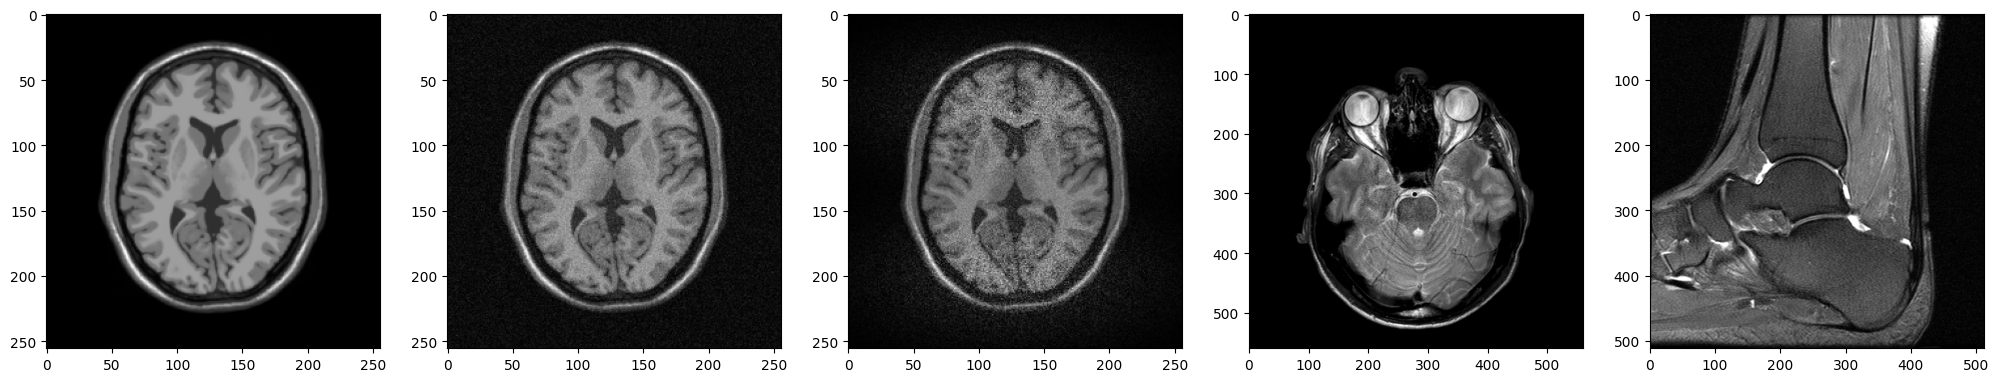

In [2]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for ax, fn in zip(axs, ["I_noisefree", "I_noisy1", "I_noisy2", "I_noisy3", "I_noisy4"]):
    ax.imshow(mat[fn], 'gray')

In [ ]:
def fgaussian(size, sigma):
    m = n = size
    h, k = m // 2, n // 2
    x, y = np.mgrid[-h:h + 1, -k:k + 1]
    g = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return g / g.sum()

In [ ]:
def non_local_means(img, v=11, n=5, alpha=0.2, sigma=8):
    # note: obszar przeszukiwań zawiera konteksty
    v += n//2 * 2 # increasing the search area to make sure all pixels have a context
    filter = fgaussian(n, sigma)
    v_gaus = lambda x: filter * x
    img = img.astype(np.float64)
    new_img = np.zeros(img.shape)
    for x in range(v // 2, img.shape[0] - v // 2):
        for y in range(v // 2, img.shape[1] - v // 2):
            V = img[x - v // 2:x + v // 2 + 1, y - v // 2:y + v // 2 + 1]
            W_unnormalized = np.array([])
            N_x = img[x - n // 2:x + n // 2 + 1, y - n // 2:y + n // 2 + 1]
            for i in range(n // 2, V.shape[0] - n // 2):
                for j in range(n // 2, V.shape[1] - n // 2):
                    N_p = V[i - n // 2:i + n // 2 + 1, j - n // 2:j + n // 2 + 1]
                    w_exp = np.exp(
                        # sqrt from L2 and **2 cancel each other 
                        -np.sum((v_gaus(N_p) - v_gaus(N_x)) ** 2)
                        / (alpha * sigma ** 2)
                    )
                    W_unnormalized = np.append(W_unnormalized, w_exp)
            W = W_unnormalized / np.sum(W_unnormalized)
            I = V[n // 2 : -(n // 2), n // 2 : -(n // 2)]
            new_img[x, y] = np.sum(W.reshape(I.shape) * I)
    max_val = max(new_img.flatten())
    new_img = new_img / max_val * 255

    return new_img.astype(np.uint8)
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(mat["I_noisy1"], "gray")
axs[0].set_title("Orginal")
axs[1].imshow(non_local_means(mat["I_noisy1"]), "gray")
axs[1].set_title("Non-local means")

In [ ]:
# funkcje skopiowane z głownego zestawu zadań

def classic(img, n=5, sig=8):
    filter = fgaussian(n,sig)
    W_n = sum(filter.flat)
    new_img = np.zeros(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            sum_p = 0
            for i in range(-(n//2), n//2+1):
                for j in range(-(n//2), n//2+1):
                    p_x = max(0, min(x+i, img.shape[0]-1))
                    p_y = max(0, min(y+j, img.shape[1]-1))
                    sum_p += filter[i,j] * img[p_x, p_y]
            new_img[x,y] = sum_p / W_n
    return new_img

def bilateral(img, n=5, sig=8, sig_r=25):
    filter = fgaussian(n,sig)
    gamma = lambda y: np.exp(-(y**2)/(2*sig_r**2))
    img = img.astype(np.float64)
    new_img = np.zeros(img.shape)
    for x in range(n//2, img.shape[0] - n//2):
        for y in range(n//2, img.shape[1] - n//2):
            W_n = sum(filter.flat)
            sum_p = 0
            for i in range(-(n//2), n//2+1):
                for j in range(-(n//2), n//2+1):
                    p_x = x+i
                    p_y = y+j
                    f = filter[i,j]
                    g = gamma(abs(img[p_x, p_y] - img[x, y]))
                    W_n += f * g
                    sum_p += f * g * img[p_x, p_y]
            new_img[x,y] = sum_p / W_n
    return new_img

In [ ]:
fig, axss = plt.subplots(5, 4, figsize=(20, 25))

print("Edits: 1 - classic, 2 - bilateral, 3 - non-local means")

for i, (axs, fn) in enumerate(zip(axss, ["I_noisefree", "I_noisy1", "I_noisy2", "I_noisy3", "I_noisy4"])):
    org, cl, bil, nlm = tuple(axs)
    img = mat[fn]
    
    start = timer()
    org.imshow(img, "gray")
    end = timer()
    t = round(end - start, 5)
    org.set_title(f"Orginal ({t} [s])")
    
    start = timer()
    cl.imshow(classic(img), "gray")
    end = timer()
    t = round(end - start, 5)
    cl.set_title(f"Classic ({t} [s])")
    print(f"Edit 1/3 of image {i+1}/5 done in {round(end - start, 2)} [s].")
    
    start = timer()
    bil.imshow(bilateral(img), "gray")
    end = timer()
    t = round(end - start, 5)
    bil.set_title(f"Bilateral ({t} [s])")
    print(f"Edit 2/3 of image {i+1}/5 done in {round(end - start, 2)} [s].")
    
    start = timer()
    nlm.imshow(non_local_means(img), "gray")
    end = timer()
    t = round(end - start, 5)
    nlm.set_title(f"Non-local means ({t} [s])")
    print(f"Edit 3/3 of image {i+1}/5 done in {round(end - start, 2)} [s].")

# Wnioski

Czas działania algorytmu non-local means
(szczególnie przy tej wołającej o pomstę do nieba implementacji)
jest znacznie dłuższy od konkurentów.